<a href="https://colab.research.google.com/github/wjdrnqja9/TIL/blob/main/eda/PUBG_Mini_PJT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mini Project

##프로젝트 설명

- 머신러닝 워크플로우를 완벽하게 이해하고 사용하기 위한 프로젝트입니다.
- Kaggle의 PUBG 순위 예측 대회 데이터를 사용합니다.

##데이터 설명

- PUBG 게임에서는 각 매치(matchId)에 최대 100명의 플레이어가 시작합니다.
- 플레이어는 탈락한 다른 팀이 얼마나 생존해 있는지를 기준으로 게임 종료 시 순위(winPlacePerc)가 매겨지는 팀(groupId)에 속할 수 있습니다.
- 게임에서 플레이어는 다양한 무기를 집어들고, 죽지 않은(knocked) 동료들을 되살리고, 차량을 운전하고, 수영하고, 뛰고, 쏘고, 모든 결과를 경험할 수 있습니다.
- 예를 들어 너무 멀리 떨어지거나, 멀리서 달려오다가(자기장 밖에서) 스스로 죽는 것입니다.
- 각 행에 한 플레이어의 post-game 통계를 포함하도록 포맷된 익명화된 PUBG 게임 통계를 다수 제공합니다.
- 데이터는 모든 타입(솔로, 듀오, 스쿼드, 커스텀 등)의 매치에서 가져옵니다.
- 경기당 100명 또는 그룹당 최대 4명의 플레이어가 있다는 보장은 없습니다.
- 1(1위)부터 0(100위)까지의 scaling 된, 최종 통계를 기준으로 선수의 결승 배치를 예측하는 모델을 만들어야 합니다.

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [26]:
# titanic data 불러오기
base_path = "/content/drive/MyDrive/Colab Notebooks/머신러닝/Extra Mini Projects/pubg-finish-placement-prediction/"

train = pd.read_csv(base_path + "train_V2.csv")
test = pd.read_csv(base_path + "test_V2.csv")
submission = pd.read_csv(base_path + "sample_submission_V2.csv")

### column 별 설명

- `Id - 플레이어 아이디`

- `groupId - 일치 내에서 그룹을 식별하기 위한 ID입니다. 같은 그룹의 플레이어가 다른 경기에서 플레이하는 경우 매번 다른 groupId를 갖습니다.`

- `matchId - 일치를 식별하는 ID입니다. 훈련 세트와 테스트 세트 모두에 일치하는 항목이 없습니다.`

- DBNO - 기절한 적 플레이어의 수입니다.

- Assists - 이 플레이어가 피해를 입었고 팀원들에 의해 사망한 적 플레이어의 수입니다.

- boosts - 사용된 부스트 항목의 수입니다.

- DamageDealt - 가한 총 피해량입니다. 참고: 자신이 입힌 피해는 차감됩니다.

- headshotKills - 헤드샷으로 사망한 적 플레이어의 수입니다.

- heals - 사용된 치유 아이템의 수입니다.

- killPlace - 게임 내 킬 순위

- killPoints - 플레이어의 킬 기반 외부 순위입니다. (이것을 킬만 중요한 Elo 순위라고 생각하십시오.) rankPoints에 -1 이외의 값이 있는 경우 killPoints의 0은 "없음"으로 처리되어야 합니다.

- killStreaks - 짧은 시간에 죽인 적 플레이어의 최대 수입니다.

- kills - 죽인 적 플레이어의 수.

- longKill - 사망 시 사망한 플레이어와 플레이어 사이의 최장 거리입니다. 
플레이어를 쓰러뜨리고 차를 몰면 가장 긴 킬 통계가 나올 수 있으므로 이는 오해의 소지가 있습니다.

- matchDuration - 일치 시간(초)입니다.

- matchType - 데이터의 출처인 게임 모드를 식별하는 문자열입니다. 표준 모드는 "solo", "duo", "squad", "solo-fpp", "duo-fpp" 및 "squad-fpp"입니다. 다른 모드는 이벤트 또는 사용자 지정 일치에서 가져온 것입니다.

- rankPoints - 플레이어의 Elo와 같은 순위입니다. 이 순위는 일관성이 없으며 API의 다음 버전에서 더 이상 사용되지 않으므로 주의해서 사용하십시오. -1 값은 "없음"을 대신합니다.

- revives - 이 플레이어가 팀원을 소생시킨 횟수입니다.

- rideDistance - 미터로 측정한 차량의 총 이동 거리입니다.

- roadKills - 차량에 있는 동안 킬 수입니다.

- swimDistance - 미터로 측정한 수영으로 이동한 총 거리.

- teamKills - 이 플레이어가 팀원을 죽인 횟수입니다.

- vehicleDestroys - 파괴된 차량의 수입니다.

- walkDistance - 미터로 측정한 도보로 이동한 총 거리.

- WeaponAcquired - 획득한 무기의 수입니다.

- winPoints - 승리 기반 플레이어의 외부 순위입니다. (이것을 승리만이 중요한 Elo 
순위라고 생각하십시오.) rankPoints에 -1 이외의 값이 있는 경우 winPoints의 0은 "없음"으로 처리되어야 합니다.


- numGroups - 경기에서 데이터가 있는 그룹의 수입니다.

- maxPlace - 경기에서 가장 낮은 순위. 데이터가 게재위치를 건너뛰는 경우가 있으므로 numGroups와 일치하지 않을 수 있습니다. (탈주)

- winPlacePerc - 예측 대상입니다. 이것은 백분위수 승리 배치로, 1은 1위, 0은 경기의 마지막 장소에 해당합니다. numGroups가 아닌 maxPlace에서 계산되므로 일치 항목에서 청크가 누락될 수 있습니다.

## 데이터 타입과 결측값 확인하기

In [27]:
train.tail(10)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4446956,dae05e0d743059,3902915a7a1943,97b64a07c05761,1,0,151.90,0,0,1,77,...,1,0.0,0,0.000,0,0,828.30,7,0,0.1071
4446957,2a4163ccbe0e3b,2689c981578849,eebc058a45ff13,0,1,100.00,0,0,0,32,...,1,0.0,0,0.000,0,0,363.70,2,0,0.4583
4446958,837349af7e8a35,58bc4104935623,2001300d4f5787,0,0,0.00,0,0,0,92,...,0,0.0,0,0.000,0,0,0.00,0,0,0.0000
4446959,d29bfa313ad766,ac3f1b4a56e5ad,2f3b1af94739b3,0,0,22.68,0,0,0,89,...,0,0.0,0,0.000,0,0,40.25,1,0,0.0842
4446960,69fa4c2d5431b1,2a3ad0e37fb6ce,818ccf2160343f,0,0,327.70,3,2,0,4,...,0,180.4,0,0.000,0,0,845.60,3,0,0.2414
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,...,0,1292.0,0,0.000,0,0,1019.00,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,...,0,0.0,0,0.000,0,0,81.70,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,...,0,0.0,0,2.184,0,0,788.70,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,...,2,0.0,0,0.000,0,0,2748.00,8,0,0.8000
4446965,0d8e7ed728b6fd,8c74f72fedf5ff,62a16aabcc095c,0,2,268.00,0,0,1,18,...,0,1369.0,0,0.000,0,0,1244.00,5,0,0.5464


In [28]:
train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,...,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,1.307171e+02,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,...,1.646590e-01,6.061157e+02,3.496091e-03,4.509322e+00,2.386841e-02,7.918208e-03,1.154218e+03,3.660488e+00,6.064601e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,...,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261157e-02,1.183497e+03,2.456544e+00,7.397004e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,...,0.000000e+00,1.909750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,...,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


In [ ]:
train.corr()

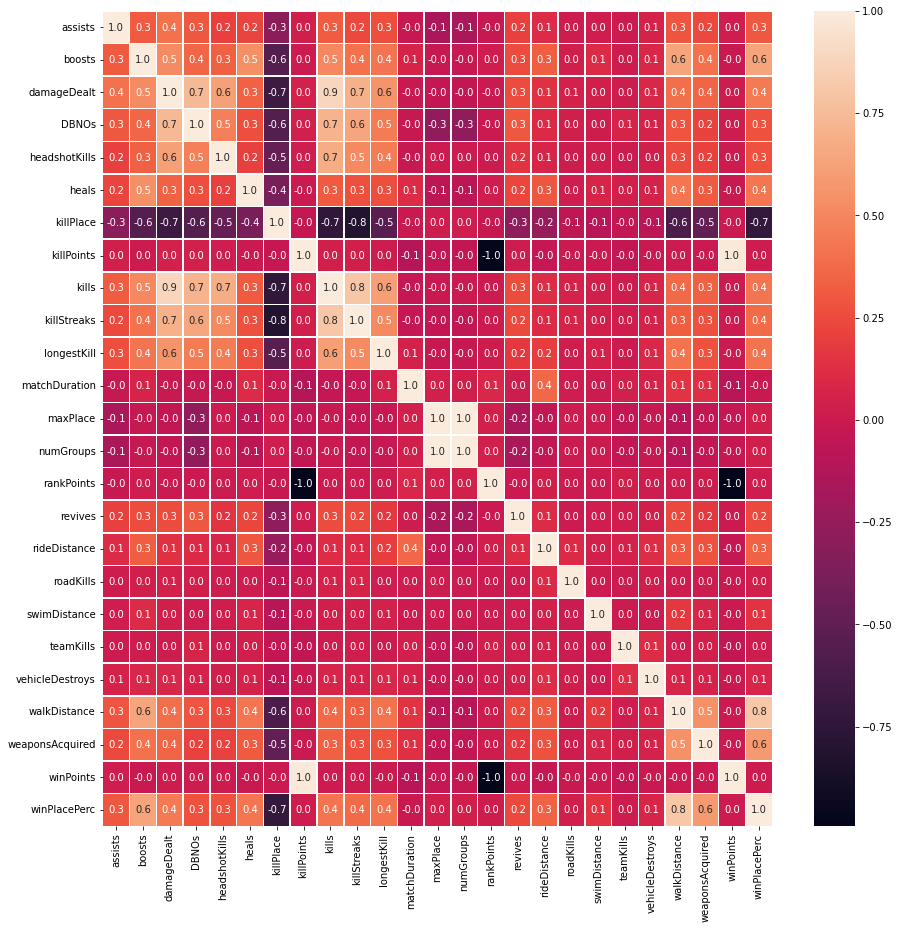

In [36]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [33]:
# 결측치 확인
train.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [35]:
# win Place Perc 결측 행 제거
train = train.dropna(axis=0)

In [18]:
# 필요 없는 컬럼 제거
train = train.drop(columns=["Id", "groupId", "matchId"])
train.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4446965 entries, 0 to 4446965
Data columns (total 26 columns):
 #   Column           Dtype  
---  ------           -----  
 0   assists          int64  
 1   boosts           int64  
 2   damageDealt      float64
 3   DBNOs            int64  
 4   headshotKills    int64  
 5   heals            int64  
 6   killPlace        int64  
 7   killPoints       int64  
 8   kills            int64  
 9   killStreaks      int64  
 10  longestKill      float64
 11  matchDuration    int64  
 12  matchType        object 
 13  maxPlace         int64  
 14  numGroups        int64  
 15  rankPoints       int64  
 16  revives          int64  
 17  rideDistance     float64
 18  roadKills        int64  
 19  swimDistance     float64
 20  teamKills        int64  
 21  vehicleDestroys  int64  
 22  walkDistance     float64
 23  weaponsAcquired  int64  
 24  winPoints        int64  
 25  winPlacePerc     float64
dtypes: float64(6), int64(19), object(1)
memory

In [37]:
# 'matchType' 종류 확인
train.matchType.unique()

array(['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo',
       'normal-squad-fpp', 'crashfpp', 'flaretpp', 'normal-solo-fpp',
       'flarefpp', 'normal-duo-fpp', 'normal-duo', 'normal-squad',
       'crashtpp', 'normal-solo'], dtype=object)

In [23]:
train['matchType'].value_counts()

squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536761
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: matchType, dtype: int64

## 데이터 분포 확인하기

In [ ]:
df['type'].unique()

array(['ORDER', 'PAYMENT', 'REFUND', 'TRANSACTION'], dtype=object)

In [ ]:
df['state'].unique()

array(['CANCELLED', 'COMPLETED', 'PENDING', 'DELETED', 'REQUESTED'],
      dtype=object)

In [ ]:
df['category_title'].unique()

array(['프로그래밍', '영상/3D', '업무 생산성', '크리에이티브', '부동산/금융', '데이터사이언스', '디자인',
       '마케팅', '교육', '투자/재테크', nan, '관리', '데이터 사이언스', '비즈니스', '지식콘텐츠',
       '일러스트', '파이낸스'], dtype=object)

In [ ]:
df['format'].unique()

array(['올인원', '스쿨 온라인', '온라인 완주반', 'RED', 'B2B 온라인', '캠프', '스쿨', nan,
       'B2B', '이벤트', '하루10분컷', '아카이브', '관리', '온라인', 'MBA', '콜로소', 'B2G'],
      dtype=object)

In [ ]:
df['method'].unique()

array(['VBANK', 'CARD', 'TRANS', 'PROMOTION', 'TRANSFER', 'ONSITE',
       'B2B_CONTRACT', nan, 'POINT', 'VOUCHER'], dtype=object)

In [ ]:
df['subcategory_title'].unique()

array(['개발자 커리어', '영상 편집', nan, 'PPT/보고서', '금융/투자 실무', '프론트엔드 개발',
       'DevOps', 'UX/UI', '머신러닝', '모션그래픽', '딥러닝/인공지능', '글쓰기/카피라이팅',
       '디지털마케팅', '엑셀/VBA', '데이터분석', '디자인툴', '모바일앱', '업무자동화', 'SNS마케팅',
       '게임', '회계/재무/세무', '부동산 개발', '시각디자인', '백엔드 개발', '데이터마케팅', '일러스트',
       '부동산 투자', '코딩 입문', '커뮤니케이션', '리더십', '주식 투자', '게임 그래픽', '데이터엔지니어링',
       'VFX'], dtype=object)

##카테고리 관련 데이터

In [ ]:
# 개인 사용자들의 데이터를 확인하기 위해 format에서 기업교육 계약, 정부 사업인 B2B, B2G 제거 후 시작
df = df[df.format.isin(['B2B', 'B2B 온라인', 'B2G'])==False]  

In [ ]:
# 카테고리  별 강의 구매 횟수
catitle = df["category_title"].value_counts()
catitle

프로그래밍       33067
데이터사이언스     14029
업무 생산성      13317
디자인         12009
영상/3D       10260
마케팅          9845
부동산/금융       5518
투자/재테크       2501
크리에이티브       2231
지식콘텐츠          56
비즈니스           40
파이낸스           24
데이터 사이언스        9
관리              2
일러스트            1
Name: category_title, dtype: int64

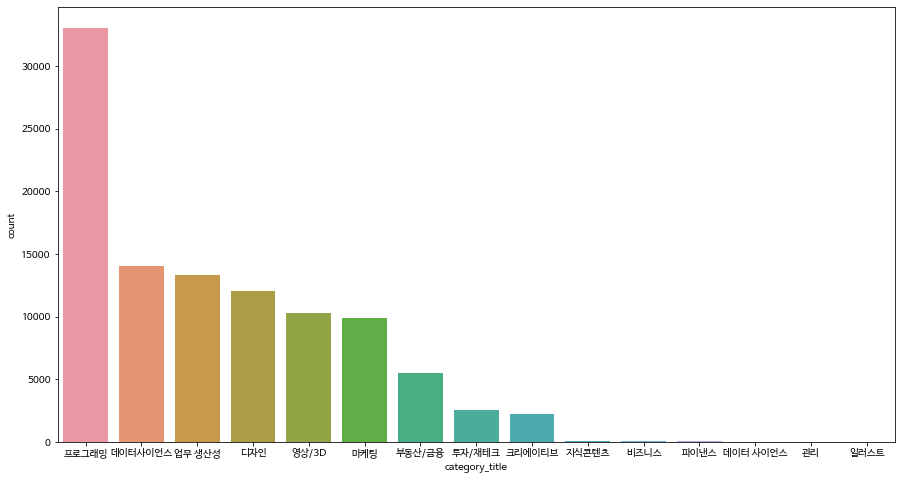

In [ ]:
# 카테고리 별 강의 구매 횟수 시각화
fig = plt.figure(figsize=(15,8))
sns.countplot( data = df, x = 'category_title' , 
              order = df['category_title'].value_counts().index )

프로그래밍 관련 강의가 가장 많이 팔렸다.

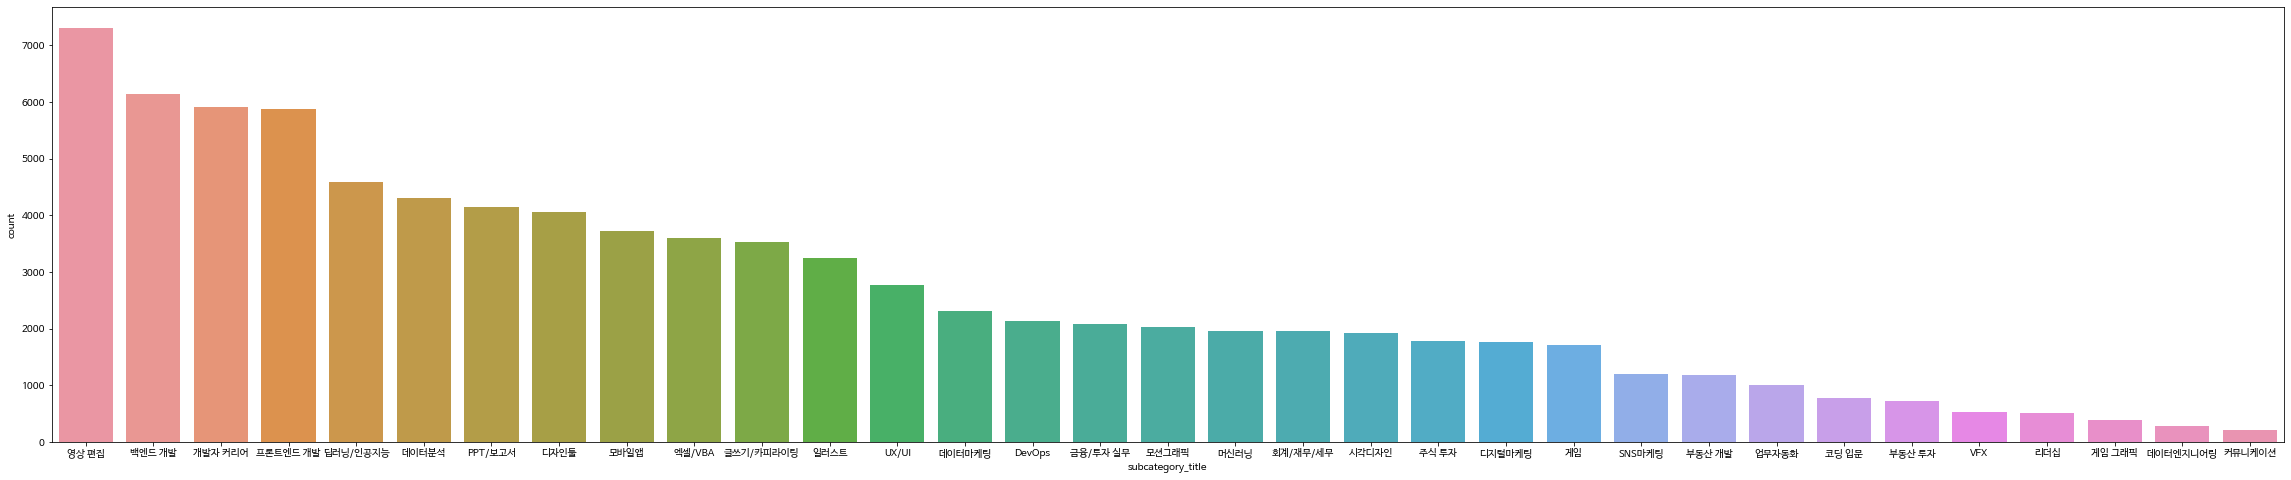

In [ ]:
# 서브카테고리 별 강의 구매 횟수 시각화
fig = plt.figure(figsize=(40,8))
sns.countplot(data = df, x = "subcategory_title", 
              order = df['subcategory_title'].value_counts().index)

하지만 subcategory로 분류시 영상 편집 강의가 가장 많았다.

In [ ]:
sub = df.groupby(['category_title', 'subcategory_title'])[['id']].count()
sub.head()

id
category_title subcategory_title      
데이터사이언스        데이터분석              4302
               데이터엔지니어링            275
               딥러닝/인공지능           4590
               머신러닝               1958
디자인            UX/UI              2775

In [ ]:
# 트리맵 해보기

In [ ]:
# 카테고리 별 총 수입
how = {                                        
    'transaction_amount' : np.sum
}

catr = df.groupby('category_title').agg(how)
catr = catr.sort_values('transaction_amount', ascending=False)
catr

,transaction_amount
category_title,
프로그래밍,3685366923
데이터사이언스,2154247670
디자인,1472061828
마케팅,1327429094
업무 생산성,1187949355
영상/3D,1097891580
부동산/금융,944512609
크리에이티브,671730027
투자/재테크,479614745


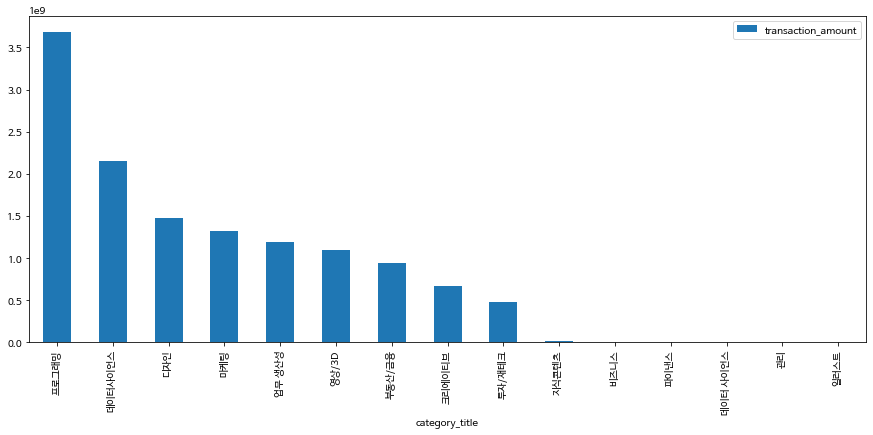

In [ ]:
# 카테고리 별 총 수입 시각화
catr.plot.bar(figsize = (15,6))

수입이 높은 카테고리의 강의 종류, 광고 늘리기

##재구매 관련 데이터

In [ ]:
# 한 사람이 강의를 몇 회 구매했는지 확인
df["customer_id"].value_counts() 

98685.0     78
50769.0     62
40783.0     59
496508.0    54
23171.0     51
            ..
545656.0     1
550306.0     1
550303.0     1
168905.0     1
610626.0     1
Name: customer_id, Length: 52178, dtype: int64

In [ ]:
repeat = df.customer_id.value_counts().loc[df.customer_id.value_counts() >= 2]
repeat_index=repeat.index
repeat_index

Float64Index([ 98685.0,  50769.0,  40783.0, 496508.0,  23171.0, 427973.0,
              158374.0,  20784.0, 106662.0, 276705.0,
              ...
              403091.0, 639015.0, 605225.0, 519796.0, 113405.0,  48967.0,
              173849.0, 526243.0, 463248.0, 172581.0],
             dtype='float64', length=24765)

In [ ]:
df["customer_id"].value_counts() >= 2

98685.0      True
50769.0      True
40783.0      True
496508.0     True
23171.0      True
            ...  
545656.0    False
550306.0    False
550303.0    False
168905.0    False
610626.0    False
Name: customer_id, Length: 52178, dtype: bool

In [ ]:
repeat_index.isin([98685]).any() == True

True

In [ ]:
# 재구매 시 True, 1회 구매시 False 인 column 생성
def repeat_order_func(x) :      

    if repeat_index.isin([x]).any()==True:
        return True
    else:
        return False

df['repeat_order'] = df['customer_id'].map(repeat_order_func)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
df['repeat_order'].value_counts()

True     75517
False    27416
Name: repeat_order, dtype: int64

In [ ]:
# 재구매자만 있는 데이터프레임
df_repeat_order = df[df.repeat_order.isin([True])]

In [ ]:
# 강의를 1회만 구매한 사람 비율
re = df.customer_id.value_counts().loc[df.customer_id.value_counts() > 1]  

len(re)/len(df.customer_id.value_counts()) * 100

47.46253210165204

강의를 2회 이상 구매한 사람이 전체의 약47.5%

###쿠폰 사용

In [ ]:
df['coupon_title'].count()

31779

In [ ]:
# 강의 구매 시 쿠폰 사용 비율
print(df['coupon_title'].count()/(df['coupon_title'].count()+df['coupon_title'].isna().sum())*100)

30.87348080790417


In [ ]:
# 재구매 시 쿠폰 사용 비율
print(df_repeat_order['coupon_title'].count()/(df_repeat_order['coupon_title'].count()+df_repeat_order['coupon_title'].isna().sum())*100)

29.349682852867566


In [ ]:
# 사용 횟수 200회 이상인 쿠폰
df.coupon_title.value_counts().loc[df.coupon_title.value_counts() > 200]

[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰                              5498
[WELCOME] 온라인 강의 3만원 할인쿠폰                             3206
[웰컴쿠폰] 올인원 패키지 1만원 할인 쿠폰                              2469
[WELCOME] 온라인 강의 2만원 할인쿠폰                             2325
[WELCOME] 온라인 강의 1만원 할인쿠폰                             1900
8월 1+1 프로모션 쿠폰                                        1458
4월 1+1 페이백 이벤트 쿠폰                                     1350
[웰컴쿠폰] 올인원 패키지 3만원 할인 쿠폰                              1284
[미래투자금] 온라인 강의 2만원 할인쿠폰                               1274
5월 페이백 프로모션 쿠폰                                        1126
7월 100% 페이백 프로모션 쿠폰                                   1101
수강생 50만명 돌파 기념 감사제 쿠폰                                  875
[일주일한정] 플러스 친구 1만원 즉시할인 쿠폰                             601
[럭키룰렛] 올인원패키지                                          595
[웰컴쿠폰] 온라인 완주반 10% 할인 쿠폰                               588
[미래투자금] 온라인 강의 1만원 할인쿠폰                                475
한 번에 끝내는 Java/Sring 웹 개발 마스터 초격차 패키지 무료 쿠폰 (-2/28)     3

In [ ]:
# 재구매 시 사용 횟수 200회 이상인 쿠폰
df_repeat_order.coupon_title.value_counts().loc[df_repeat_order.coupon_title.value_counts() > 200]

[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰      4135
[웰컴쿠폰] 올인원 패키지 1만원 할인 쿠폰      1877
[WELCOME] 온라인 강의 3만원 할인쿠폰     1575
4월 1+1 페이백 이벤트 쿠폰             1261
[WELCOME] 온라인 강의 2만원 할인쿠폰     1214
8월 1+1 프로모션 쿠폰                1195
5월 페이백 프로모션 쿠폰                1066
[WELCOME] 온라인 강의 1만원 할인쿠폰     1056
[웰컴쿠폰] 올인원 패키지 3만원 할인 쿠폰       998
7월 100% 페이백 프로모션 쿠폰            901
수강생 50만명 돌파 기념 감사제 쿠폰          574
[럭키룰렛] 올인원패키지                  521
[미래투자금] 온라인 강의 2만원 할인쿠폰        513
[웰컴쿠폰] 온라인 완주반 10% 할인 쿠폰       471
[일주일한정] 플러스 친구 1만원 즉시할인 쿠폰     449
6월 반값특가 프로모션 쿠폰                232
[미래투자금] 온라인 강의 1만원 할인쿠폰        205
[20% 할인] 완주반 1주년 기념 쿠폰         203
Name: coupon_title, dtype: int64

재구매 시 쿠폰 사용 비율이 전체 쿠폰 사용 비율보다 적게 나온다.

재구매 시 사용할 수 있는 쿠폰을 여러 종류 발행한다면 강의를 재구매하는 사용자가 늘어나 매출이 증가 할 것으로 예상된다.

##환불 관련 데이터

In [ ]:
# type 열에서 PAYMENT, REFUND 이외 제거
df_ORDER_delete = df[df.type.isin(['PAYMENT', 'REFUND'])]  
df_ORDER_delete.head(2)

,id,customer_id,course_id,type,state,course_title,category_title,format,completed_at,transaction_amount,...,sale_price,tax_free_amount,pg,method,subcategory_title,marketing_start_at,repeat_order,period,period_quartile,completed_month
2,970657,72297.0,204246.0,PAYMENT,COMPLETED,시크릿코드 : 프론트엔드 실무 완성편,프로그래밍,스쿨 온라인,2021-03-28 15:21:43,171810,...,190900.0,190900.0,NaN,CARD,NaN,2021-03-04,True,24 days 15:21:43,~30일,None
4,970658,478028.0,201797.0,PAYMENT,COMPLETED,올인원 패키지 : 직장인 필수 스킬 3종 세트 MAX,업무 생산성,올인원,2021-03-28 15:21:54,97500,...,117500.0,117500.0,NaN,CARD,PPT/보고서,2019-11-14,True,500 days 15:21:54,250일 초과,None


In [ ]:
# 결제, 환불 value_counts
df_ORDER_delete['type'].value_counts()

PAYMENT    59437
REFUND      3642
Name: type, dtype: int64

In [ ]:
# 환불율
print(f'{"%0.4f"%(3824/(3824+61433)*100)}%')

5.8599%


In [ ]:
# 환불 0% 시 매출 상승률
print(f'{"%0.4f"%(100/(100-5.86)*100)}%')

106.2248%


환불 문제 해결 시 약 6%의 매출 상승을 기대할 수 있다.

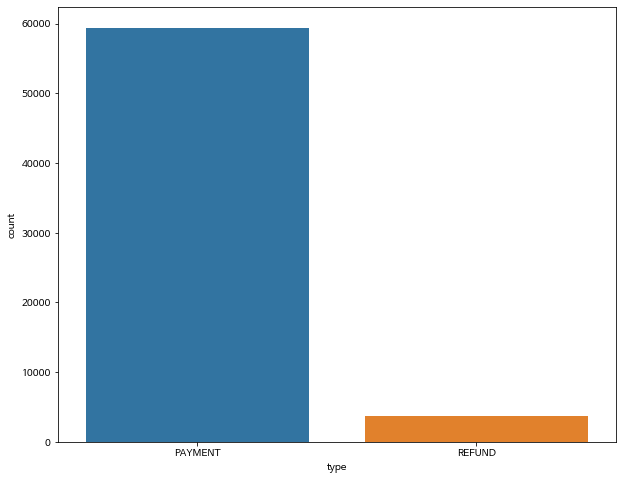

In [ ]:
# 결제, 환불 count
fig = plt.figure(figsize=(10,8)) 
sns.countplot(data = df_ORDER_delete, x = "type", order = df_ORDER_delete['type'].value_counts().index)

In [ ]:
# 판매 시작일로부터 강의 구매일 사이의 기간
df['period']=df['completed_at']-df['marketing_start_at']
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,customer_id,course_id,type,state,course_title,category_title,format,completed_at,transaction_amount,...,sale_price,tax_free_amount,pg,method,subcategory_title,marketing_start_at,repeat_order,period,period_quartile,completed_month
0,970634,504760.0,201435.0,ORDER,CANCELLED,올인원 패키지 : 알고리즘 기술면접 완전 정복,프로그래밍,올인원,2021-03-28 15:00:11,90500,...,110500.0,110500.0,NaN,VBANK,개발자 커리어,NaT,False,NaT,250일 초과,None
1,970650,432862.0,203178.0,ORDER,CANCELLED,초격차 패키지 : 한번에 끝내는 영상 촬영과 편집,영상/3D,올인원,2021-03-28 15:16:53,96000,...,116000.0,116000.0,NaN,CARD,영상 편집,2020-12-02,False,116 days 15:16:53,~250일,None
2,970657,72297.0,204246.0,PAYMENT,COMPLETED,시크릿코드 : 프론트엔드 실무 완성편,프로그래밍,스쿨 온라인,2021-03-28 15:21:43,171810,...,190900.0,190900.0,NaN,CARD,NaN,2021-03-04,True,24 days 15:21:43,~30일,None
3,970656,72297.0,204246.0,ORDER,CANCELLED,시크릿코드 : 프론트엔드 실무 완성편,프로그래밍,스쿨 온라인,2021-03-28 15:21:43,171810,...,190900.0,190900.0,NaN,CARD,NaN,2021-03-04,True,24 days 15:21:43,~30일,None
4,970658,478028.0,201797.0,PAYMENT,COMPLETED,올인원 패키지 : 직장인 필수 스킬 3종 세트 MAX,업무 생산성,올인원,2021-03-28 15:21:54,97500,...,117500.0,117500.0,NaN,CARD,PPT/보고서,2019-11-14,True,500 days 15:21:54,250일 초과,None


In [ ]:
df['period'].describe()

count                          87439
mean     180 days 22:49:56.259666738
std      203 days 07:49:05.552178536
min                -7 days +04:12:20
25%                 30 days 15:05:52
50%                101 days 12:51:54
75%                250 days 22:15:17
max                950 days 16:45:00
Name: period, dtype: object

In [ ]:
# 판매 시작일로부터 강의 구매일 사이의 기간 4분위로 구분
def func(x) :                                     

    if x <= datetime.timedelta(days=30): 
        return "~30일"
    elif x <= datetime.timedelta(days=101):
        return "~101일"
    elif x <= datetime.timedelta(days=250):
        return "~250일"
    else:
        return "250일 초과"


df['period_quartile'] = df['period'].map(func)
df['period_quartile'].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    250일 초과
1      ~250일
2       ~30일
3       ~30일
4    250일 초과
Name: period_quartile, dtype: object

In [ ]:
# type이 환불인 데이터만 
df_refund = df[df.type=='REFUND']
df_refund.head()

,id,customer_id,course_id,type,state,course_title,category_title,format,completed_at,transaction_amount,...,sale_price,tax_free_amount,pg,method,subcategory_title,marketing_start_at,repeat_order,period,period_quartile,completed_month
651,972377,444760.0,204122.0,REFUND,COMPLETED,퍼포먼스 마케터 되기 온라인 완주반 2기,마케팅,온라인 완주반,2021-03-29 09:24:43,-147000,...,404000.0,404000.0,NaN,VBANK,NaN,NaT,False,NaT,250일 초과,None
652,972381,472666.0,203178.0,REFUND,COMPLETED,초격차 패키지 : 한번에 끝내는 영상 촬영과 편집,영상/3D,올인원,2021-03-29 09:26:13,-96000,...,116000.0,116000.0,NaN,CARD,영상 편집,2020-12-02,False,117 days 09:26:13,~250일,None
666,972409,447177.0,203989.0,REFUND,COMPLETED,올인원 패키지 : 소금툰과 함께 캐릭터 드로잉/굿즈/임티/컷툰,디자인,올인원,2021-03-29 09:40:54,-79000,...,89000.0,89000.0,NaN,CARD,일러스트,2021-02-19,False,38 days 09:40:54,~101일,None
672,972422,373915.0,204264.0,REFUND,COMPLETED,데이터분석 프로젝트+자격증 온라인 완주반 3기,데이터사이언스,온라인 완주반,2021-03-29 09:44:01,-340000,...,340000.0,340000.0,NaN,VBANK,NaN,2021-03-08,False,21 days 09:44:01,~30일,None
675,972436,456086.0,NaN,REFUND,COMPLETED,프로모션 :연봉 앞자리가 바뀌는 프론트엔드 한끝세트 (3월 프리패스),프로그래밍,올인원,2021-03-29 09:47:17,-299000,...,299000.0,299000.0,NaN,CARD,NaN,NaT,False,NaT,250일 초과,None


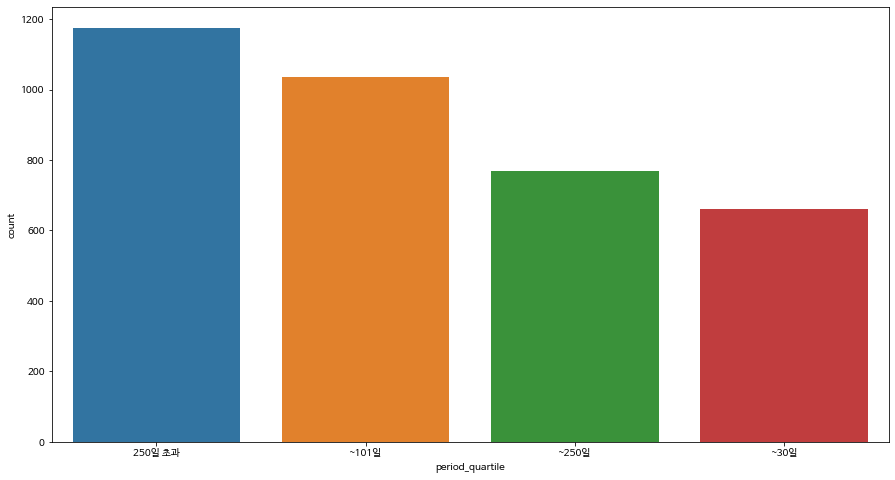

In [ ]:
# 판매 시작일로부터 강의 구매일 사이의 기간 4분위 별 환불 횟수
fig = plt.figure(figsize=(15,8))                    
sns.countplot( data = df_refund, x = 'period_quartile' , 
              order = df_refund['period_quartile'].value_counts().index )

판매 시작한지 250일 초과된 데이터의 환불 횟수가 가장 크게,
30일 이하인 데이터가 가장 적게 나타났다.

-> 판매 시작한지 오래된 강의들을 재편성

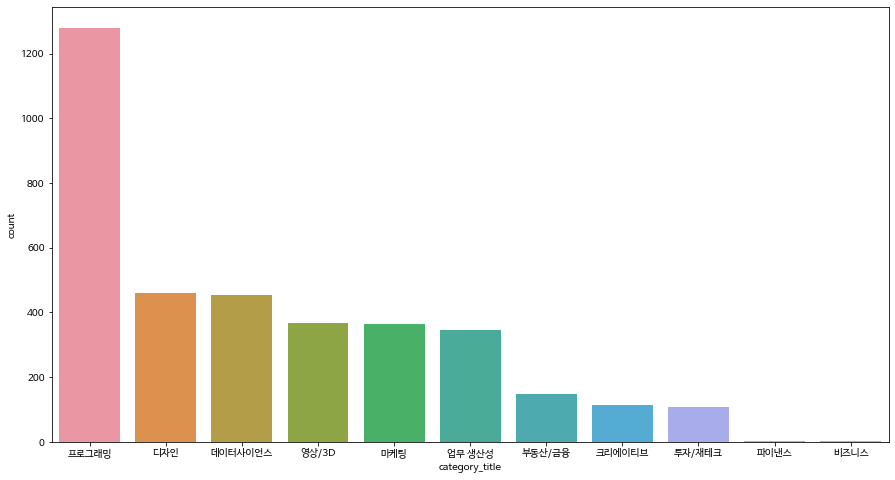

In [ ]:
# 카테고리 별 환불 횟수
fig = plt.figure(figsize=(15,8))
sns.countplot( data = df_refund, x = 'category_title' , 
              order = df_refund['category_title'].value_counts().index )

In [ ]:
# 카테고리 별 환불 비율
df_refund_rate=df_refund['category_title'].value_counts()/df_ORDER_delete['category_title'].value_counts()*100 
df_refund_rate = df_refund_rate.sort_values(ascending=False)
df_refund_rate

크리에이티브      10.531221
파이낸스         8.333333
마케팅          6.362210
프로그래밍        6.220235
디자인          6.124083
비즈니스         5.882353
영상/3D        5.631636
데이터사이언스      5.455202
투자/재테크       5.376884
업무 생산성       4.417773
부동산/금융       4.276221
관리                NaN
데이터 사이언스          NaN
지식콘텐츠             NaN
Name: category_title, dtype: float64

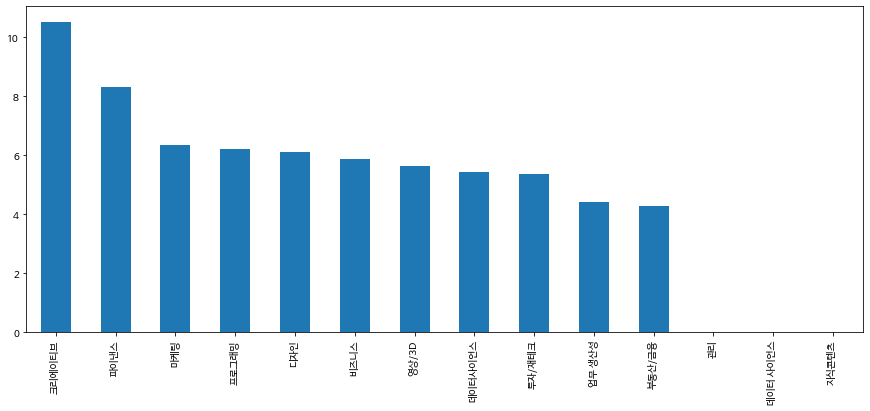

In [ ]:
# 카테고리 별 환불 비율 그래프
df_refund_rate.plot.bar(figsize = (15,6)) 

환불 비율이 높은 카테고리의 강의의 질 높이기

##결제 시기에 따른 데이터

In [ ]:
df['completed_at'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  102933
unique                  96415
top       2021-08-27 15:17:38
freq                       22
first     2021-03-28 15:00:11
last      2021-09-25 14:25:47
Name: completed_at, dtype: object

In [ ]:
# 결제 월 컬럼 추가
def func(x) :                                     

    if datetime.date(2021,4,1) <= x < datetime.date(2021,5,1):   # 3월은 28일부터, 9월은 25일까지밖에 없으므로 제외
        return "4월"
    elif datetime.date(2021,5,1) <= x < datetime.date(2021,6,1):
        return "5월"
    elif datetime.date(2021,6,1) <=  x < datetime.date(2021,7,1):
        return "6월"
    elif datetime.date(2021,7,1) <=  x < datetime.date(2021,8,1):
        return "7월"
    elif datetime.date(2021,8,1) <= x < datetime.date(2021,9,1):
        return "8월"

df['completed_month'] = df['completed_at'].map(func)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  
/usr/local/lib/python3.7/di

,id,customer_id,course_id,type,state,course_title,category_title,format,completed_at,transaction_amount,...,sale_price,tax_free_amount,pg,method,subcategory_title,marketing_start_at,repeat_order,period,period_quartile,completed_month
0,970634,504760.0,201435.0,ORDER,CANCELLED,올인원 패키지 : 알고리즘 기술면접 완전 정복,프로그래밍,올인원,2021-03-28 15:00:11,90500,...,110500.0,110500.0,NaN,VBANK,개발자 커리어,NaT,False,NaT,250일 초과,None
1,970650,432862.0,203178.0,ORDER,CANCELLED,초격차 패키지 : 한번에 끝내는 영상 촬영과 편집,영상/3D,올인원,2021-03-28 15:16:53,96000,...,116000.0,116000.0,NaN,CARD,영상 편집,2020-12-02,False,116 days 15:16:53,~250일,None
2,970657,72297.0,204246.0,PAYMENT,COMPLETED,시크릿코드 : 프론트엔드 실무 완성편,프로그래밍,스쿨 온라인,2021-03-28 15:21:43,171810,...,190900.0,190900.0,NaN,CARD,NaN,2021-03-04,True,24 days 15:21:43,~30일,None
3,970656,72297.0,204246.0,ORDER,CANCELLED,시크릿코드 : 프론트엔드 실무 완성편,프로그래밍,스쿨 온라인,2021-03-28 15:21:43,171810,...,190900.0,190900.0,NaN,CARD,NaN,2021-03-04,True,24 days 15:21:43,~30일,None
4,970658,478028.0,201797.0,PAYMENT,COMPLETED,올인원 패키지 : 직장인 필수 스킬 3종 세트 MAX,업무 생산성,올인원,2021-03-28 15:21:54,97500,...,117500.0,117500.0,NaN,CARD,PPT/보고서,2019-11-14,True,500 days 15:21:54,250일 초과,None


In [ ]:
# 월 별 총 수입
how = {                                        
    'transaction_amount' : np.sum
}

month_account = df.groupby('completed_month').agg(how)
month_account = month_account.sort_values('transaction_amount', ascending=False)

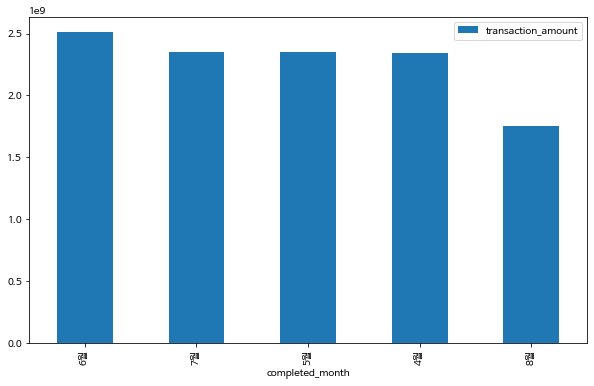

In [ ]:
# 월 별 총 수입 그래프
month_account.plot.bar(figsize = (10,6)) 

In [ ]:
def weekdays(x) :           
    if x.weekday() == 0: 
        return "월요일"
    elif x.weekday() == 1: 
        return "화요일"
    elif x.weekday() == 2: 
        return "수요일"
    elif x.weekday() == 3: 
        return "목요일"
    elif x.weekday() == 4: 
        return "금요일"
    elif x.weekday() == 5: 
        return "토요일"
    elif x.weekday() == 6: 
        return "일요일"        

df['completed_weekday'] = df['completed_at'].map(weekdays)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,customer_id,course_id,type,state,course_title,category_title,format,completed_at,transaction_amount,...,tax_free_amount,pg,method,subcategory_title,marketing_start_at,repeat_order,period,period_quartile,completed_month,completed_weekday
0,970634,504760.0,201435.0,ORDER,CANCELLED,올인원 패키지 : 알고리즘 기술면접 완전 정복,프로그래밍,올인원,2021-03-28 15:00:11,90500,...,110500.0,NaN,VBANK,개발자 커리어,NaT,False,NaT,250일 초과,None,일요일
1,970650,432862.0,203178.0,ORDER,CANCELLED,초격차 패키지 : 한번에 끝내는 영상 촬영과 편집,영상/3D,올인원,2021-03-28 15:16:53,96000,...,116000.0,NaN,CARD,영상 편집,2020-12-02,False,116 days 15:16:53,~250일,None,일요일
2,970657,72297.0,204246.0,PAYMENT,COMPLETED,시크릿코드 : 프론트엔드 실무 완성편,프로그래밍,스쿨 온라인,2021-03-28 15:21:43,171810,...,190900.0,NaN,CARD,NaN,2021-03-04,True,24 days 15:21:43,~30일,None,일요일
3,970656,72297.0,204246.0,ORDER,CANCELLED,시크릿코드 : 프론트엔드 실무 완성편,프로그래밍,스쿨 온라인,2021-03-28 15:21:43,171810,...,190900.0,NaN,CARD,NaN,2021-03-04,True,24 days 15:21:43,~30일,None,일요일
4,970658,478028.0,201797.0,PAYMENT,COMPLETED,올인원 패키지 : 직장인 필수 스킬 3종 세트 MAX,업무 생산성,올인원,2021-03-28 15:21:54,97500,...,117500.0,NaN,CARD,PPT/보고서,2019-11-14,True,500 days 15:21:54,250일 초과,None,일요일


In [ ]:
# 요일 별 총 수입
how = {                                        
    'transaction_amount' : np.sum
}

weekday_account = df.groupby('completed_weekday').agg(how)
weekday_account = weekday_account.sort_values('transaction_amount', ascending=False)

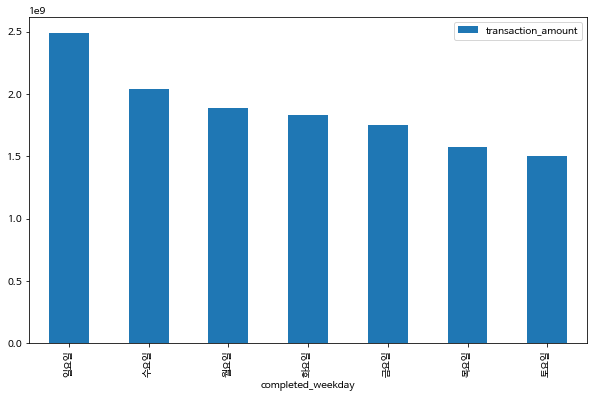

In [ ]:
# 요일 별 총 수입 그래프
weekday_account.plot.bar(figsize = (10,6)) 

In [ ]:
x = datetime.date(2021,4,10)
x.day

10

In [ ]:
# 결제 일 컬럼 추가
def days(x) :  
    if x < datetime.date(2021,4,1) or x >= datetime.date(2021,9,1):     # 3월은 28일부터, 9월은 25일까지밖에 없으므로 제외
        return None
    else:          
        return x.day
    

df['completed_day'] = df['completed_at'].map(days)
df.loc[12000, 'completed_day']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


11.0

In [ ]:
# 일 별 총 수입
how = {                                        
    'transaction_amount' : np.sum
}

day_account = df.groupby('completed_day').agg(how)
day_account = day_account.sort_values('transaction_amount', ascending=False)

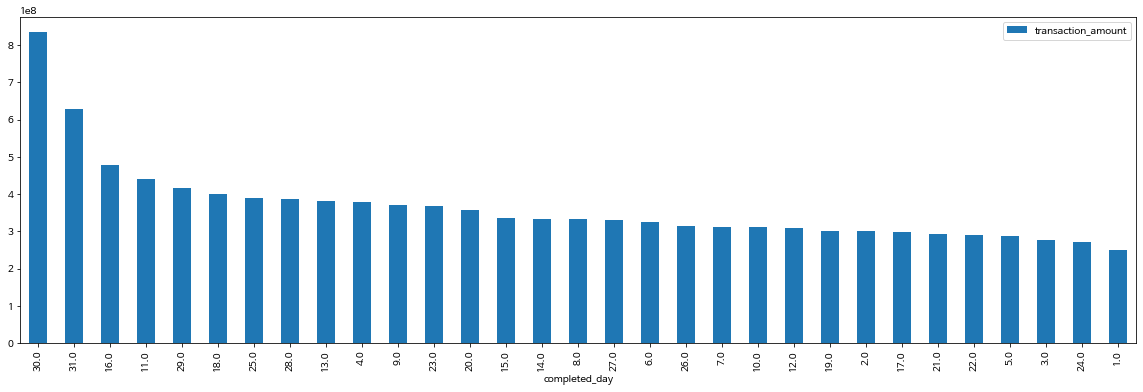

In [ ]:
# 일 별 총 수입 그래프
day_account.plot.bar(figsize = (20,6)) 

방학시즌인 6,7월, 주말인 일요일, 그리고 월말인 30,31일에 수입이 높게 나타난다.

  ->  매출 높은 시기에 광고 늘리기

In [ ]:
# 월 말에 가장 잘 팔리는 강의 카테고리
